In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2 as scipyChi2

# This is a custom module I wrote to assist data analysis for Phys 20 lab series.
from CSVexplorer import CSVexplorer, chi2, setAx

# Some Re:0 colors, color blind proof.
# Also pretty cute :P
color = [
    (143/255,  78/255, 180/255),#purple
    (208/255, 134/255, 188/255),#pink
    ( 71/255, 142/255, 219/255),#blue
]

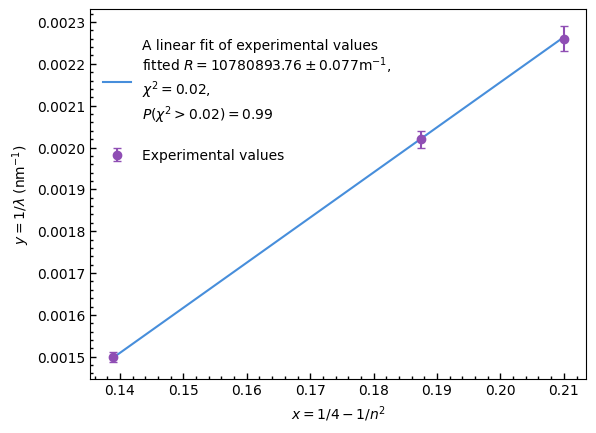

In [2]:
# Data extraction
hydrogen = CSVexplorer("data_new.csv", ignoreRow = [1,2,6,7,8,9])
unknown = CSVexplorer("data_sampleA.csv", ignoreRow = 1)
hydrogen.convertType(["lambda", "delta lambda", "1/lambda", "delta 1/lambda"], float)
hydrogen.convertContainer(["lambda", "delta lambda", "1/lambda", "delta 1/lambda"], np.array)
unknown.convertType(["lambda"], float)
unknown.convertContainer(["lambda"], np.array)
# Generate x values from n
n = np.array([5, 4, 3])
x = 1/4 - 1 / n ** 2

# Fitting
linModel = lambda x, R: R * x
v, cov = curve_fit(linModel, x, hydrogen["1/lambda"], sigma = hydrogen["delta 1/lambda"])
R = v[0] # Rydberg's const in 1/nm
dR = cov[0][0]
fitChi2 = chi2(hydrogen["1/lambda"], linModel(x, R), hydrogen["delta 1/lambda"])
chi2p = scipyChi2.cdf(fitChi2, 2)

# Plot
fig, ax = plt.subplots()
setAx(ax)
ax.set_xlabel(r"$x=1/4 - 1/n^2$")
ax.set_ylabel(r"$y=1/\lambda$ ($\mathrm{nm}^{-1}$)")
ax.errorbar(x, hydrogen["1/lambda"], yerr = hydrogen["delta 1/lambda"],
           fmt = 'o', capsize = 3, color = color[0], label = "Experimental values"
)

ax.plot(x, linModel(x, R), color = color[2], label =\
fr"""
A linear fit of experimental values
fitted $R={R*1e9:#.10g}\pm{dR*1e9:#.2g}\mathrm{{m}}^{{-1}}$,
$\chi^2={fitChi2:.2f}$,
$P(\chi^2>{fitChi2:.2f})={1-chi2p:.2f}$
""")
ax.legend(frameon = False)


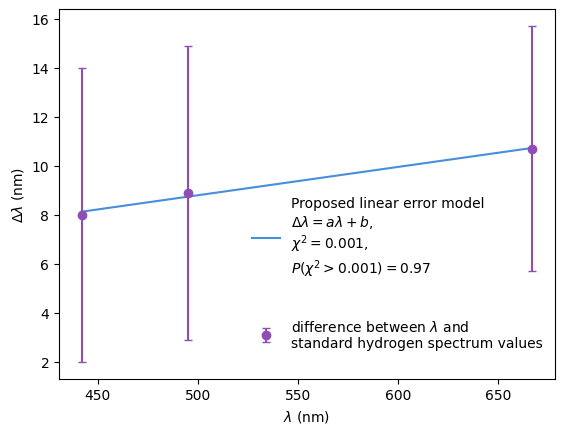

In [3]:
idealH = np.array([434.0, 486.1, 656.3])
fig, bx = plt.subplots()
bx.set_ylabel(r"$\Delta\lambda$ (nm)")
bx.set_xlabel(r"$\lambda$ (nm)")
bx.errorbar(hydrogen["lambda"], hydrogen["lambda"] - idealH, yerr = hydrogen["delta lambda"],
            fmt = 'o', capsize = 3, color = color[0],
            label =\
r"""
difference between $\lambda$ and
standard hydrogen spectrum values
""")

deltaModel = lambda lbd, a, b: a * lbd + b
v, cov = curve_fit(deltaModel, hydrogen["lambda"],
                   hydrogen["lambda"] - idealH, sigma = hydrogen["delta lambda"])

a = v[0]
b = v[1]
da = cov[0][0]
db = cov[1][1]

deltaChi2 = chi2(hydrogen["lambda"] - idealH,
                 deltaModel(hydrogen["lambda"], a, b),
                 hydrogen["delta lambda"],
                 dof = 2)
deltaChi2p = scipyChi2.cdf(deltaChi2, 1)

bx.plot(hydrogen["lambda"], deltaModel(hydrogen["lambda"], a, b), color = color[2], label = \
fr"""
Proposed linear error model
$\Delta\lambda = a\lambda+b$,
$\chi^2={deltaChi2:.3f}$,
$P(\chi^2>{deltaChi2:.3f})={1-deltaChi2p:.2f}$
""")

bx.legend(frameon = False)

[419.04913083 435.85251587 449.69059767 516.90413784 541.61499819
 563.36055531 591.03671891 602.89793188]


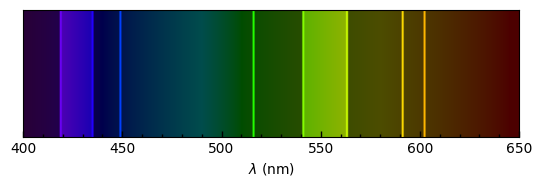

In [5]:
def WavelengthToRGB(wave):
    # This is a port of javascript code from  http://stackoverflow.com/a/14917481
    gamma = 0.8
    intensity_max = 1
 
    if wave < 380:
        red, green, blue = 0, 0, 0
    elif wave < 440:
        red = -(wave - 440) / (440 - 380)
        green, blue = 0, 1
    elif wave < 490:
        red = 0
        green = (wave - 440) / (490 - 440)
        blue = 1
    elif wave < 510:
        red, green = 0, 1
        blue = -(wave - 510) / (510 - 490)
    elif wave < 580:
        red = (wave - 510) / (580 - 510)
        green, blue = 1, 0
    elif wave < 645:
        red = 1
        green = -(wave - 645) / (645 - 580)
        blue = 0
    elif wave <= 780:
        red, green, blue = 1, 0, 0
    else:
        red, green, blue = 0, 0, 0
 
    # let the intensity fall of near the vision limits
    if wave < 380:
        factor = 0
    elif wave < 420:
        factor = 0.3 + 0.7 * (wave - 380) / (420 - 380)
    elif wave < 700:
        factor = 1
    elif wave <= 780:
        factor = 0.3 + 0.7 * (780 - wave) / (780 - 700)
    else:
        factor = 0
 
    def f(c):
        if c == 0:
            return 0
        else:
            return intensity_max * pow (c * factor, gamma)
 
    return f(red), f(green), f(blue)

corrected = unknown.getColumn("lambda") - deltaModel(unknown["lambda"], a, b)
print(corrected)

spectrum = np.zeros((64, 650, 3))
for lbd in range(400, 650):
    for y in range(0,64):
        spectrum[y][lbd] = WavelengthToRGB(lbd)
        if lbd in corrected.astype(int):
            continue
        elif lbd > corrected[0] and lbd < corrected[1]:
            spectrum[y][lbd] = WavelengthToRGB(lbd)
            spectrum[y][lbd] = spectrum[y][lbd] * 0.7
        elif lbd > corrected[4] and lbd < corrected[5]:
            spectrum[y][lbd] = WavelengthToRGB(lbd)
            spectrum[y][lbd] = spectrum[y][lbd] * 0.7
        else:
            spectrum[y][lbd] *= 0.3
            

fig, cx = plt.subplots()
setAx(cx)
cx.set_xlim(400, 650)
cx.set_xlabel(r"$\lambda$ (nm)")
cx.yaxis.set_visible(False)
cx.imshow(spectrum)